In [11]:
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
import xarray as xr

In [12]:
def estimate_lag(series1, series2):
    """Estimate the lag between two time series using cross-correlation."""
    # Remove NaNs
    valid_indices = np.logical_and(~np.isnan(series1), ~np.isnan(series2))
    series1_clean = series1[valid_indices]
    series2_clean = series2[valid_indices]

    # Compute cross-correlation
    correlation = np.correlate(series1_clean - np.mean(series1_clean), 
                               series2_clean - np.mean(series2_clean), 
                               mode='full')
    
    # Find the lag that gives the maximum correlation
    lag = np.argmax(correlation) - (len(series1_clean) - 1)
    return lag

## Two buoy example

In [19]:
# Generate synthetic temperature data for two buoys with a time lag
n_time = 100  # Number of time points
time = np.linspace(0, 10, n_time)

# Buoy 1: Baseline temperature data with a decaying trend and sinusoidal variability
temperature_buoy1 = 20 + 5 * np.exp(-0.2 * time) + 1.5 * np.sin(2 * np.pi * time / 5) + np.random.normal(0, 0.5, n_time)

# Buoy 2: Temperature data is similar to Buoy 1 but with a time lag
true_lag = 5  # Known time lag between the two buoys (in time points)
temperature_buoy2 = 20 + 5 * np.exp(-0.2 * time) + 1.5 * np.sin(2 * np.pi * time / 5 + 1) + np.random.normal(0, 1, n_time)

# Introduce missing data (NaNs) in both buoys
temperature_buoy1_with_missing = temperature_buoy1.copy()
temperature_buoy2_with_missing = temperature_buoy2.copy()
temperature_buoy1_with_missing[np.random.choice(n_time, size=10, replace=False)] = np.nan
temperature_buoy2_with_missing[np.random.choice(n_time, size=10, replace=False)] = np.nan

# Step 1: Estimate the lag using Pandas correlation

# Estimate the lag between Buoy 1 and Buoy 2
estimated_lag = estimate_lag(temperature_buoy1_with_missing, temperature_buoy2_with_missing)
print(f"True Lag: {true_lag}, Estimated Lag: {estimated_lag}")

# Prepare data for GPR
coords1 = np.column_stack([np.zeros(n_time), time])  # Buoy 1 coordinates (lat = 0 for simplicity)
coords2 = np.column_stack([np.ones(n_time), time])   # Buoy 2 coordinates (lat = 1 for simplicity)

all_coords = np.vstack([coords1, coords2])  # Stack coordinates for both buoys
all_temperature = np.concatenate([temperature_buoy1_with_missing, temperature_buoy2_with_missing])

# Filter out valid (non-NaN) data for GPR
valid_indices = ~np.isnan(all_temperature)
valid_coords = all_coords[valid_indices]
valid_temperature = all_temperature[valid_indices]

# Step 4: Gaussian Process Regression (GPR)
# Define GPR kernel (RBF kernel + Bias for the 2D input: buoy and time)
kernel = GPy.kern.RBF(input_dim=2, lengthscale=1.0, variance=1.0) + GPy.kern.Bias(input_dim=2)

# GPR model using the valid (non-missing) data
gpr_model = GPy.models.GPRegression(valid_coords, valid_temperature[:, None], kernel)
gpr_model.optimize()

# Predict temperature values for the entire dataset (including missing data)
gpr_pred, gpr_var = gpr_model.predict(all_coords)

# Reshape predictions back to separate Buoy 1 and Buoy 2
gpr_pred_buoy1 = gpr_pred[:n_time].flatten()
gpr_pred_buoy2 = gpr_pred[n_time:].flatten()

# Step 5: Shift the GPR predictions for Buoy 2 back
if estimated_lag > 0:
    gpr_pred_buoy2_shifted = gpr_pred_buoy2[:-estimated_lag]  # Crop to remove the shifted portion
else:
    gpr_pred_buoy2_shifted = gpr_pred_buoy2[-estimated_lag:]  # Crop to remove the shifted portion

# Step 6: Shift the original observations for Buoy 2
if estimated_lag > 0:
    temperature_buoy2_shifted = temperature_buoy2_with_missing[:-estimated_lag]  # Crop to remove the shifted portion
else:
    temperature_buoy2_shifted = temperature_buoy2_with_missing[-estimated_lag:]  # Crop to remove the shifted portion

True Lag: 5, Estimated Lag: 2


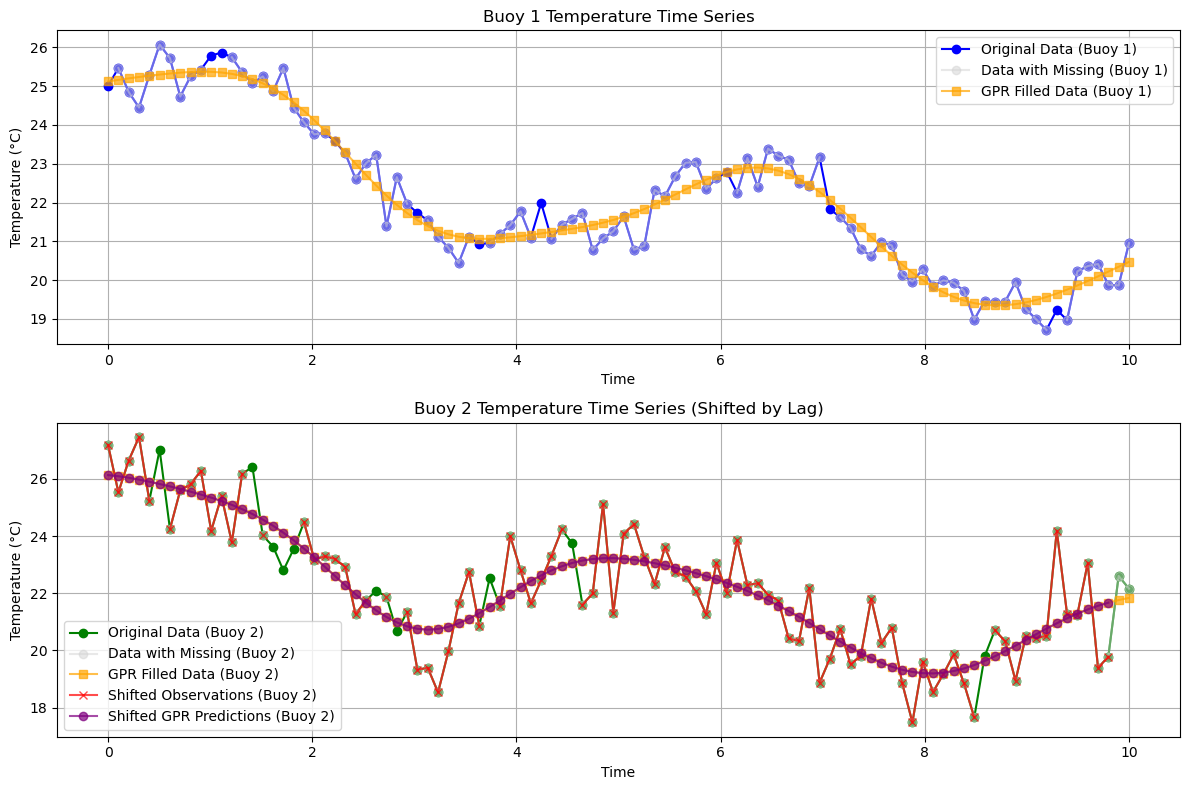

In [20]:
# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Plot Buoy 1: Original, Missing, and GPR-filled data
axs[0].plot(time, temperature_buoy1, 'o-', label='Original Data (Buoy 1)', color='blue')
axs[0].plot(time, temperature_buoy1_with_missing, 'o-', label='Data with Missing (Buoy 1)', color='lightgray', alpha=0.5)
axs[0].plot(time, gpr_pred_buoy1, 's-', label='GPR Filled Data (Buoy 1)', color='orange', alpha=0.7)
axs[0].set_title('Buoy 1 Temperature Time Series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend()
axs[0].grid(True)

# Plot Buoy 2: Original, Missing, GPR-filled, shifted observations and shifted GPR predictions
axs[1].plot(time, temperature_buoy2, 'o-', label='Original Data (Buoy 2)', color='green')
axs[1].plot(time, temperature_buoy2_with_missing, 'o-', label='Data with Missing (Buoy 2)', color='lightgray', alpha=0.5)
axs[1].plot(time, gpr_pred_buoy2, 's-', label='GPR Filled Data (Buoy 2)', color='orange', alpha=0.7)

# Plot shifted observations for Buoy 2
axs[1].plot(time[:len(temperature_buoy2_shifted)], temperature_buoy2_shifted, 'x-', 
            label='Shifted Observations (Buoy 2)', color='red', alpha=0.7)

# Plot shifted GPR predictions for Buoy 2
axs[1].plot(time[:len(gpr_pred_buoy2_shifted)], gpr_pred_buoy2_shifted, 'o-', 
            label='Shifted GPR Predictions (Buoy 2)', color='purple', alpha=0.7)

axs[1].set_title('Buoy 2 Temperature Time Series (Shifted by Lag)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Temperature (°C)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


## A many buoy example

In [21]:
# Function to create an xarray dataset for multiple buoys with mixed lags
def create_buoy_data(n_time, n_buoys):
    time = np.linspace(0, 10, n_time)
    dataset = xr.Dataset()

    # Generate temperature data for the first buoy (no lag)
    temperature_buoy1 = (
        20 + 5 * np.exp(-0.2 * time) + 
        1.5 * np.sin(2 * np.pi * time / 5) + 
        np.random.normal(0, 0.5, n_time)
    )
    
    # Store first buoy data
    dataset['buoy_1'] = (('time'), temperature_buoy1)
    dataset['buoy_1_true'] = (('time'), temperature_buoy1)  # For reference

    # Generate temperatures for each subsequent buoy with mixed lags
    for i in range(1, n_buoys):
        # Define lag: positive for some, negative for others
        if i % 2 == 0:  # Even index for positive lag
            lag = i // 2 * 0.1  # Positive lag
        else:  # Odd index for negative lag
            lag = -((i + 1) // 2) * 0.1  # Negative lag

        # Create temperature data for the buoy, applying lag
        temperature_with_lag = (
            20 + 5 * np.exp(-0.2 * time) + 
            i * 1.5 * np.sin(2 * np.pi * (time - lag) / 5) +  # Apply lag to sine function
            np.random.normal(0, i * 0.5, n_time)
        )

        # Introduce missing data (NaNs)
        temperature_with_missing = temperature_with_lag.copy()
        temperature_with_missing[np.random.choice(n_time, size=10, replace=False)] = np.nan
        
        # Store in xarray dataset
        dataset[f'buoy_{i+1}'] = (('time'), temperature_with_missing)
        dataset[f'buoy_{i+1}_true'] = (('time'), temperature_with_lag)  # For reference

    dataset['time'] = (('time'), time)
    return dataset

# GPR and shifting process for the dataset
def process_buoys(dataset):
    n_buoys = len(dataset.data_vars) // 2  # Half are temperature, half are true values
    results = {}
    
    for i in range(n_buoys):
        # Select buoy data
        buoy_data = dataset[f'buoy_{i+1}']
        buoy_true = dataset[f'buoy_{i+1}_true']
        
        # Estimate lag with respect to the first buoy
        if i == 0:
            estimated_lag = 0
        else:
            estimated_lag = estimate_lag(dataset['buoy_1'].values, buoy_data.values)
        
        results[f'buoy_{i+1}'] = {
            'lag': estimated_lag,
            'predictions': None,
            'shifted_data': None,
            'shifted_predictions': None
        }

        # Prepare coordinates for GPR
        coords = np.column_stack([np.full(buoy_data.size, i), dataset['time'].values])
        
        # GPR model using only valid data
        valid_indices = ~np.isnan(buoy_data)
        valid_coords = coords[valid_indices]
        valid_temperature = buoy_data[valid_indices].values[:, None]

        kernel = GPy.kern.RBF(input_dim=2, lengthscale=1.0, variance=1.0) + GPy.kern.Bias(input_dim=2)
        gpr_model = GPy.models.GPRegression(valid_coords, valid_temperature, kernel)
        gpr_model.optimize()
        
        # Predict temperature values for the entire dataset (including missing data)
        gpr_pred, gpr_var = gpr_model.predict(coords)
        results[f'buoy_{i+1}']['predictions'] = gpr_pred.flatten()

        # Shift the observations and predictions
        if estimated_lag > 0:
            results[f'buoy_{i+1}']['shifted_data'] = buoy_data.values[:-estimated_lag]
            results[f'buoy_{i+1}']['shifted_predictions'] = gpr_pred.flatten()[:-estimated_lag]
        elif estimated_lag < 0:
            results[f'buoy_{i+1}']['shifted_data'] = buoy_data.values[-estimated_lag:]
            results[f'buoy_{i+1}']['shifted_predictions'] = gpr_pred.flatten()[-estimated_lag:]
        else:
            results[f'buoy_{i+1}']['shifted_data'] = buoy_data.values
            results[f'buoy_{i+1}']['shifted_predictions'] = gpr_pred.flatten()
    
    return results

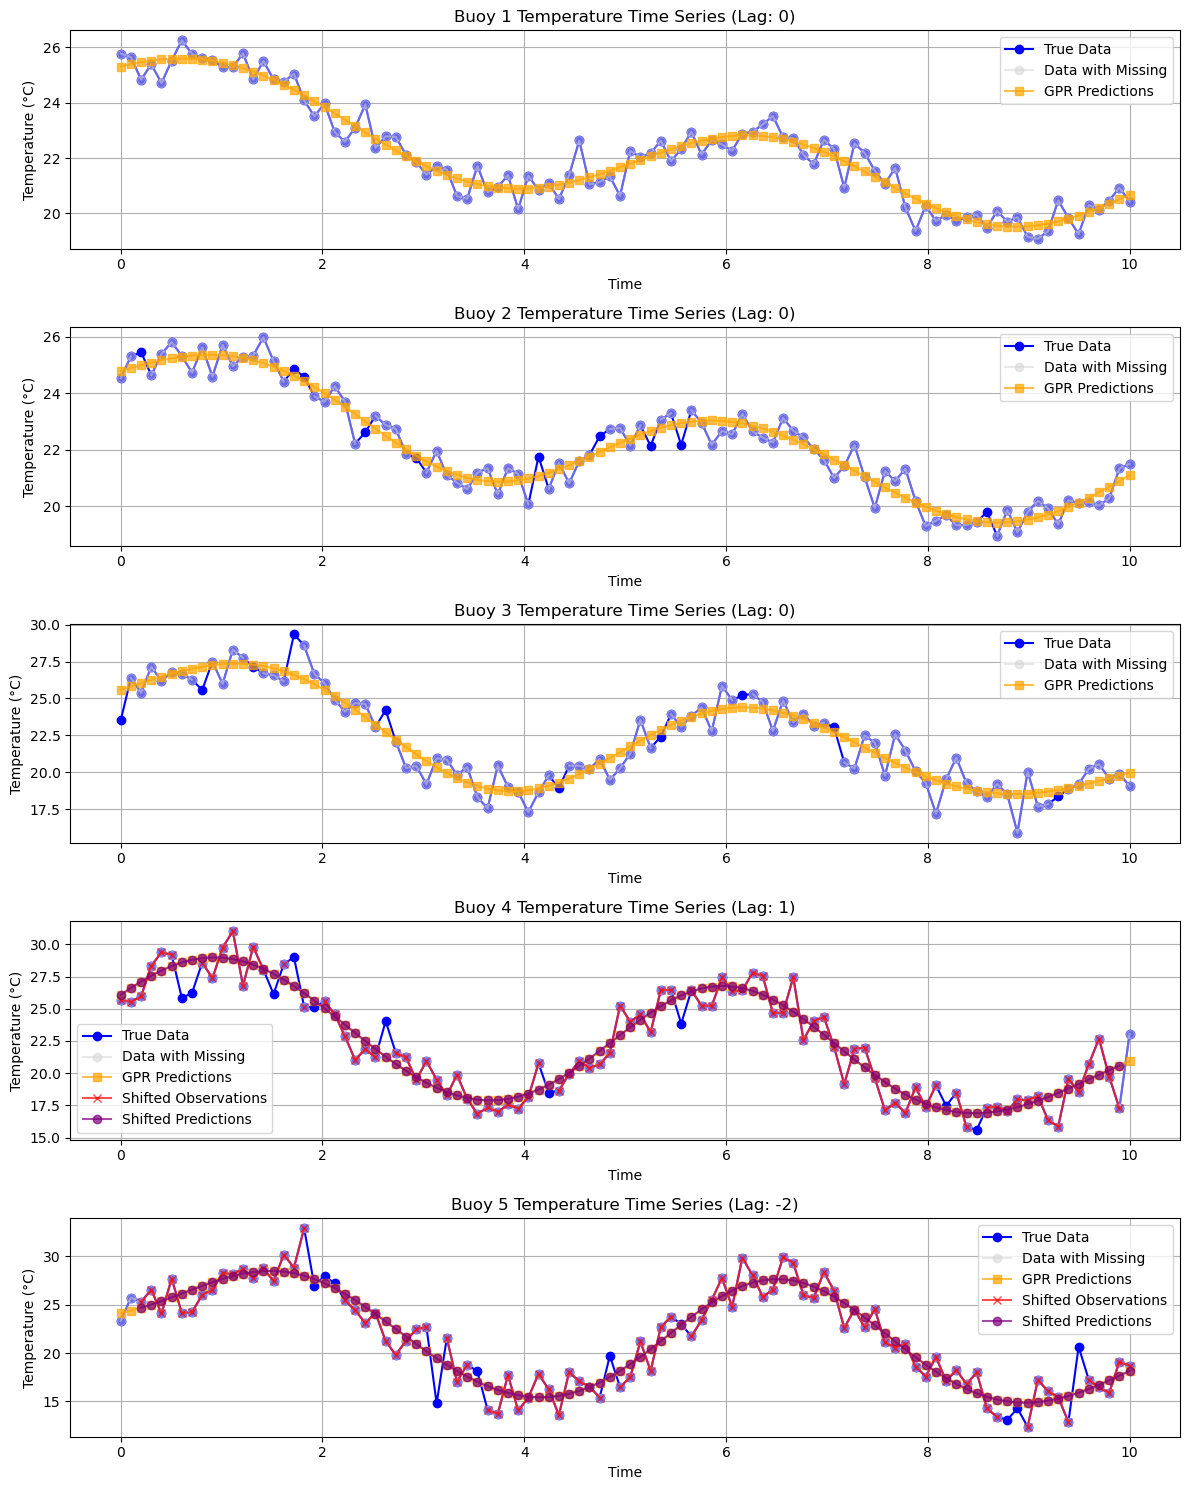

In [22]:
# Create the buoy dataset with 5 buoys
n_time = 100
n_buoys = 5
buoy_dataset = create_buoy_data(n_time, n_buoys)

# Process the buoys to estimate lags and apply GPR
buoy_results = process_buoys(buoy_dataset)

# Visualization of the results
fig, axs = plt.subplots(n_buoys, 1, figsize=(12, 3 * n_buoys))

for i in range(n_buoys):
    buoy_data = buoy_dataset[f'buoy_{i+1}']
    buoy_true = buoy_dataset[f'buoy_{i+1}_true']
    shifted_data = buoy_results[f'buoy_{i+1}']['shifted_data']
    shifted_predictions = buoy_results[f'buoy_{i+1}']['shifted_predictions']
    
    axs[i].plot(buoy_dataset['time'], buoy_true, 'o-', label='True Data', color='blue')
    axs[i].plot(buoy_dataset['time'], buoy_data, 'o-', label='Data with Missing', color='lightgray', alpha=0.5)
    axs[i].plot(buoy_dataset['time'], buoy_results[f'buoy_{i+1}']['predictions'], 's-', label='GPR Predictions', color='orange', alpha=0.7)
    
    # Plot shifted data and predictions
    if buoy_results[f'buoy_{i+1}']['lag'] > 0:
        axs[i].plot(buoy_dataset['time'][:-buoy_results[f'buoy_{i+1}']['lag']], 
                    shifted_data, 'x-', label='Shifted Observations', color='red', alpha=0.7)
        axs[i].plot(buoy_dataset['time'][:-buoy_results[f'buoy_{i+1}']['lag']], 
                    shifted_predictions, 'o-', label='Shifted Predictions', color='purple', alpha=0.7)
    elif buoy_results[f'buoy_{i+1}']['lag'] < 0:
        axs[i].plot(buoy_dataset['time'][-buoy_results[f'buoy_{i+1}']['lag']:],
                    shifted_data, 'x-', label='Shifted Observations', color='red', alpha=0.7)
        axs[i].plot(buoy_dataset['time'][-buoy_results[f'buoy_{i+1}']['lag']:],
                    shifted_predictions, 'o-', label='Shifted Predictions', color='purple', alpha=0.7)
    
    axs[i].set_title(f'Buoy {i + 1} Temperature Time Series (Lag: {buoy_results[f"buoy_{i + 1}"]["lag"]})')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Temperature (°C)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()
